# Классическое обучение с подкреплением

In [2]:
import numpy as np
import pygame
pygame.init()

pygame 2.5.2 (SDL 2.28.3, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


(5, 0)

## Метод Q-learning

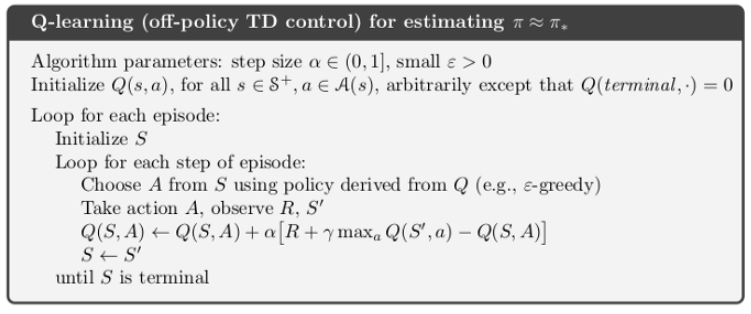

In [3]:
# Класс окружение
class Environment():

    def __init__(self, worldmap):
        self.worldmap = worldmap
        self.height, self.width = self.worldmap.shape

    def returnState(self, position, action):
        new_position = position
        if action == 'right':
            new_position = [position[0]+1, position[1]]
        if action == 'left':
            new_position = [position[0]-1, position[1]]
        if action == 'down':
            new_position = [position[0], position[1]+1]
        if action == 'up':
            new_position = [position[0], position[1]-1]

        if new_position[0] >= 0 and new_position[0] < self.width and\
        new_position[1] >= 0 and new_position[1] < self.height and\
        self.worldmap[new_position[1],new_position[0]] != 1:
            return new_position
        else:
            return position

    def returnReward(self, position):
        if self.worldmap[position[1],position[0]] == 2: # food
            return 10
        elif self.worldmap[position[1],position[0]] == 3: # danger
            return -100
        else:
            return -1

# Класс аганта
class Agent():

    def __init__(self, env_size=(10, 10), start=[0,0]):
        self.position = start
        self.actions = ['right', 'left', 'down', 'up']
        self.total_reward_each_eps = []
        self.epsilon = .3 # Exploration vs Exploitation
        self.alpha = 0.1
        self.gamma = 1
        self.q_table = {}
        env_height, env_width = env_size
        for i in range(env_width):
            for j in range(env_height):
                self.q_table[(i, j)] = {}
                for a in self.actions:
                    self.q_table[(i, j)][a] = 0  # Q value is a dict of dicts

    def chooseAction(self, position):
        epsilon = self.epsilon
        # Epsilon greedy strategy
        if np.random.uniform(0, 1) <= epsilon:# explore
            return np.random.choice(self.actions)
        else:# exploit
            return max(self.q_table[tuple(position)], key=self.q_table[tuple(position)].get)

    def update(self, cur_state, new_state, action, reward):
        self.q_table[tuple(cur_state)][action] += \
        self.alpha*(reward + \
                    self.gamma*max([self.q_table[tuple(new_state)][val] for val in self.q_table[tuple(new_state)]]) -\
                    self.q_table[tuple(cur_state)][action])


# Класс игры
class Game():

    def __init__(self, worldmap):
        self.worldmap = worldmap
        i,j = np.where(self.worldmap == -1)
        self.startfinish = [j[0],i[0]]
        #
        self.environment = Environment(self.worldmap.copy())
        self.agent = Agent(env_size=self.worldmap.shape, start=self.startfinish)
        #
        self.training = True
        self.episode = 0
        self.score = 0

    def reset(self):
        self.score = np.sum(self.agent.total_reward_each_eps)
        self.environment.worldmap = self.worldmap.copy()
        self.agent.position = self.startfinish
        self.agent.total_reward_each_eps = []
        self.episode += 1

    def one_step_simulate(self, agent):
        cur_state = agent.position
        action = agent.chooseAction(cur_state)
        new_state = self.environment.returnState(cur_state, action)
        reward = self.environment.returnReward(new_state)
        agent.total_reward_each_eps.append(reward)
        if self.training: agent.update(cur_state, new_state, action, reward)
        agent.position = new_state

    def simulate(self, num_episode=1000):
        for episode in range(num_episode):
            while True:
                self.one_step_simulate(self.agent)
                cur_state = self.agent.position
                if self.environment.worldmap[cur_state[1],cur_state[0]] == 3 or \
                self.environment.worldmap[cur_state[1],cur_state[0]] == 2:
                    self.reset()
                    break
        return None

    def pygame_render(self, screen, corner = [10, 10]):
        # world
        for i in range(self.environment.width):
            for j in range(self.environment.height):
                if self.environment.worldmap[j,i] == 1:
                    pygame.draw.rect(screen, (150,150,150), (corner[0]+scale*i, corner[1]+scale*j, scale, scale), 2)
                elif self.environment.worldmap[j,i] == 2:
                    pygame.draw.rect(screen, (0,150,0), (corner[0]+scale*i, corner[1]+scale*j, scale, scale), 0)
                elif self.environment.worldmap[j,i] == 3:
                    pygame.draw.rect(screen, (150,0,0), (corner[0]+scale*i, corner[1]+scale*j, scale, scale), 0)
                else:
                    center = (int(corner[0]+scale*(i+.5)), int(corner[1]+scale*(j+.5)))
                    corn1 = [corner[0]+scale*i, corner[1]+scale*j]
                    corn2 = [corner[0]+scale*(i+1), corner[1]+scale*j]
                    corn3 = [corner[0]+scale*(i+1), corner[1]+scale*(j+1)]
                    corn4 = [corner[0]+scale*i, corner[1]+scale*(j+1)]

                    food = 120/10
                    danger = -120/100
                    if self.agent.q_table[(i,j)]['right'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j)]['right']*food),0), \
                                         [center,corn2,corn3])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j)]['right']*danger),0,0), \
                                         [center,corn2,corn3])
                    if self.agent.q_table[(i,j)]['left'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j)]['left']*food),0), \
                                         [center,corn1,corn4])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j)]['left']*danger),0,0), \
                                         [center,corn1,corn4])
                    if self.agent.q_table[(i,j)]['down'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j)]['down']*food),0), \
                                         [center,corn3,corn4])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j)]['down']*danger),0,0), \
                                         [center,corn3,corn4])
                    if self.agent.q_table[(i,j)]['up'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j)]['up']*food),0), \
                                         [center,corn1,corn2])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j)]['up']*danger),0,0), \
                                         [center,corn1,corn2])

        pygame.draw.rect(screen, (0,0,0), \
                         (corner[0], corner[1], scale*self.environment.width, scale*self.environment.height), 4)
        # agent
        pygame.draw.circle(screen, (255,255,255), \
                           (int(corner[0]+scale*(self.agent.position[0]+.5)), \
                            int(corner[1]+scale*(self.agent.position[1]+.5))), \
                           scale//2.5, 4)



### Прогулка по обрыву

In [4]:
# масштаб и расположение игрового поля в окне
scale = 50
topleft = [50,20]

#  0 - обычная ячейка
#  1 - стена
# -1 - стартовая ячейка
#  2 - целевая ячейка (конец эпизода)
#  3 - ячейка с ловушкой (конец эпизода)
#
world = np.array([ [0,0,0,0,0,0,0,0,0,0,0,0], \
                   [0,0,0,0,0,0,0,0,0,0,0,0], \
                   [0,0,0,0,0,0,0,0,0,0,0,0], \
                  [-1,3,3,3,3,3,3,3,3,3,3,2]])
values = {}

game = Game(world)
print(game.worldmap)

if values == {}:
    game.simulate(50) # количество эпизодов обучения в фоновом режиме
else:
    game.agent.q_table = values

[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [-1  3  3  3  3  3  3  3  3  3  3  2]]


In [5]:
bg_color = (255,255,255)
(width,height) = (900,280)

pygame.display.init()
myfont1 = pygame.font.SysFont("monospace", 12)
screen = pygame.display.set_mode((width,height))
pygame.display.set_caption("RL")

game.training = True # демонстрация без обучения
time = 0
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    time += 1
    if time % 30 == 0:
        game.one_step_simulate(game.agent)
        cur_state = game.agent.position
        if game.environment.worldmap[cur_state[1],cur_state[0]] == 3 or \
        game.environment.worldmap[cur_state[1],cur_state[0]] == 2:
            game.reset()
    screen.fill(bg_color)
    game.pygame_render(screen, topleft)
    screen.blit(myfont1.render("episode: "+str(game.episode), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]))
    screen.blit(myfont1.render("prev score: "+"{:2.1f}".format(game.score), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]+15))
    #screen.blit(myfont1.render("exploration: "+"{:1.3f}".format(game.agent.epsilon), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]+30))
    #screen.blit(myfont1.render("learning rate: "+"{:1.3f}".format(game.agent.alpha), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]+45))


    pygame.display.update()


pygame.display.quit()

### Произвольный лабиринт

In [6]:
# масштаб и расположение игрового поля в окне
scale = 50
topleft = [50,20]

#  0 - обычная ячейка
#  1 - стена
# -1 - стартовая ячейка
#  2 - целевая ячейка (конец эпизода)
#  3 - ячейка с ловушкой (конец эпизода)
#
world = np.array([[-1,0,0,1,0,0,0], \
                  [0,0,0,1,0,0,0], \
                  [0,0,0,0,0,0,0], \
                  [0,0,1,1,1,0,0], \
                  [3,0,0,0,1,0,0], \
                  [0,1,1,1,1,0,3], \
                  [0,1,2,0,0,0,0]])
values = {}

game = Game(world)
print(game.worldmap)

if values == {}:
    game.simulate(80) # количество эпизодов обучения в фоновом режиме
else:
    game.agent.q_table = values

[[-1  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1  1  1  0  0]
 [ 3  0  0  0  1  0  0]
 [ 0  1  1  1  1  0  3]
 [ 0  1  2  0  0  0  0]]


In [7]:
bg_color = (255,255,255)
(width,height) = (640,480)

pygame.display.init()
myfont1 = pygame.font.SysFont("monospace", 12)
screen = pygame.display.set_mode((width,height))
pygame.display.set_caption("RL")

game.training = True # демонстрация без обучения
time = 0
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    time += 1
    if time % 30 == 0:
        game.one_step_simulate(game.agent)
        cur_state = game.agent.position
        if game.environment.worldmap[cur_state[1],cur_state[0]] == 3 or \
        game.environment.worldmap[cur_state[1],cur_state[0]] == 2:
            game.reset()
    screen.fill(bg_color)
    game.pygame_render(screen, topleft)
    screen.blit(myfont1.render("episode: "+str(game.episode), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]))
    screen.blit(myfont1.render("prev score: "+"{:2.1f}".format(game.score), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]+15))
    #screen.blit(myfont1.render("exploration: "+"{:1.3f}".format(game.agent.epsilon), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]+30))
    #screen.blit(myfont1.render("learning rate: "+"{:1.3f}".format(game.agent.alpha), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]+45))


    pygame.display.update()


pygame.display.quit()

## Метод Q-learning. Достижение последовательно двух целей

In [ ]:
class Environment():

    def __init__(self, worldmap):
        self.worldmap = worldmap
        self.height, self.width = self.worldmap.shape

    def returnState(self, position, action):
        new_position = position
        if action == 'right':
            new_position = [position[0]+1, position[1]]
        if action == 'left':
            new_position = [position[0]-1, position[1]]
        if action == 'down':
            new_position = [position[0], position[1]+1]
        if action == 'up':
            new_position = [position[0], position[1]-1]

        if new_position[0] >= 0 and new_position[0] < self.width and\
        new_position[1] >= 0 and new_position[1] < self.height and\
        self.worldmap[new_position[1],new_position[0]] != 1:
            return new_position
        else:
            return position

    def returnReward(self, position, sated):
        if self.worldmap[position[1],position[0]] == 2 and sated == 0: # food
            return 10
        elif self.worldmap[position[1],position[0]] == -1 and sated == 1: # return
            return 10
        elif self.worldmap[position[1],position[0]] == 3: # danger
            return -100
        else:
            return -1


class Agent():

    def __init__(self, env_size=(10, 10), start=[0,0]):
        self.position = start
        self.actions = ['right', 'left', 'down', 'up']
        self.total_reward_each_eps = []
        self.epsilon = .3 # Exploration vs Exploitation
        self.alpha = 0.1
        self.gamma = 1
        self.sated = 0
        self.q_table = {}
        env_height, env_width = env_size
        for i in range(env_width):
            for j in range(env_height):
                # туда
                self.q_table[(i, j, 0)] = {}
                for a in self.actions:
                    self.q_table[(i, j, 0)][a] = 0  # Q value is a dict of dicts
                # обратно
                self.q_table[(i, j, 1)] = {}
                for a in self.actions:
                    self.q_table[(i, j, 1)][a] = 0  # Q value is a dict of dicts

    def chooseAction(self, position):
        epsilon = self.epsilon
        # Epsilon greedy strategy
        if np.random.uniform(0, 1) <= epsilon:# explore
            return np.random.choice(self.actions)
        else:# exploit
            return max(self.q_table[tuple(position+[self.sated])], key=self.q_table[tuple(position+[self.sated])].get)

    def update(self, cur_state, new_state, action, reward):
        self.q_table[tuple(cur_state+[self.sated])][action] += \
        self.alpha*(reward + \
                    self.gamma*max([self.q_table[tuple(new_state+[self.sated])][val] \
                                    for val in self.q_table[tuple(new_state+[self.sated])]]) -\
                    self.q_table[tuple(cur_state+[self.sated])][action])



class Game():

    def __init__(self, worldmap):
        self.worldmap = worldmap
        i,j = np.where(self.worldmap == -1)
        self.startfinish = [j[0],i[0]]
        #
        self.environment = Environment(self.worldmap.copy())
        self.agent = Agent(env_size=self.worldmap.shape, start=self.startfinish)
        #
        self.training = True
        self.episode = 0
        self.score = 0

    def reset(self):
        self.score = np.sum(self.agent.total_reward_each_eps)
        self.environment.worldmap = self.worldmap.copy()
        self.agent.position = self.startfinish
        self.agent.sated = 0
        self.agent.total_reward_each_eps = []
        self.episode += 1

    def one_step_simulate(self, agent):
        cur_state = agent.position
        action = agent.chooseAction(cur_state)
        new_state = self.environment.returnState(cur_state, action)
        reward = self.environment.returnReward(new_state, agent.sated)
        agent.total_reward_each_eps.append(reward)
        if self.training: agent.update(cur_state, new_state, action, reward)
        agent.position = new_state
        if reward == 10: agent.sated = 1

    def simulate(self, num_episode=1000):
        for episode in range(num_episode):
            while True:
                self.one_step_simulate(self.agent)
                cur_state = self.agent.position
                if self.environment.worldmap[cur_state[1],cur_state[0]] == 3 or \
                (self.environment.worldmap[cur_state[1],cur_state[0]] == -1 and self.agent.sated == 1):
                    self.reset()
                    break
        return None

    def pygame_render(self, screen, corner = [10, 10]):
        # world
        for i in range(self.environment.width):
            for j in range(self.environment.height):
                if self.environment.worldmap[j,i] == 1:
                    pygame.draw.rect(screen, (150,150,150), (corner[0]+scale*i, corner[1]+scale*j, scale, scale), 2)
                elif self.environment.worldmap[j,i] == 2 and self.agent.sated == 0:
                    pygame.draw.rect(screen, (0,150,0), (corner[0]+scale*i, corner[1]+scale*j, scale, scale), 0)
                elif self.environment.worldmap[j,i] == -1 and self.agent.sated == 1:
                    pygame.draw.rect(screen, (0,150,0), (corner[0]+scale*i, corner[1]+scale*j, scale, scale), 0)
                elif self.environment.worldmap[j,i] == 3:
                    pygame.draw.rect(screen, (150,0,0), (corner[0]+scale*i, corner[1]+scale*j, scale, scale), 0)
                else:
                    center = (int(corner[0]+scale*(i+.5)), int(corner[1]+scale*(j+.5)))
                    corn1 = [corner[0]+scale*i, corner[1]+scale*j]
                    corn2 = [corner[0]+scale*(i+1), corner[1]+scale*j]
                    corn3 = [corner[0]+scale*(i+1), corner[1]+scale*(j+1)]
                    corn4 = [corner[0]+scale*i, corner[1]+scale*(j+1)]

                    food = 120/10
                    danger = -120/100
                    if self.agent.q_table[(i,j,self.agent.sated)]['right'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j,self.agent.sated)]['right']*food),0), \
                                         [center,corn2,corn3])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j,self.agent.sated)]['right']*danger),0,0), \
                                         [center,corn2,corn3])
                    if self.agent.q_table[(i,j,self.agent.sated)]['left'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j,self.agent.sated)]['left']*food),0), \
                                         [center,corn1,corn4])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j,self.agent.sated)]['left']*danger),0,0), \
                                         [center,corn1,corn4])
                    if self.agent.q_table[(i,j,self.agent.sated)]['down'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j,self.agent.sated)]['down']*food),0), \
                                         [center,corn3,corn4])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j,self.agent.sated)]['down']*danger),0,0), \
                                         [center,corn3,corn4])
                    if self.agent.q_table[(i,j,self.agent.sated)]['up'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j,self.agent.sated)]['up']*food),0), \
                                         [center,corn1,corn2])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j,self.agent.sated)]['up']*danger),0,0), \
                                         [center,corn1,corn2])

        pygame.draw.rect(screen, (0,0,0), \
                         (corner[0], corner[1], scale*self.environment.width, scale*self.environment.height), 4)
        # agent
        pygame.draw.circle(screen, (255,255,255), \
                           (int(corner[0]+scale*(self.agent.position[0]+.5)), \
                            int(corner[1]+scale*(self.agent.position[1]+.5))), \
                           scale//2.5, 4)



In [ ]:
# масштаб и расположение игрового поля в окне
scale = 50
topleft = [50,20]

#  0 - обычная ячейка
#  1 - стена
# -1 - стартовая ячейка
#  2 - целевая ячейка (конец эпизода)
#  3 - ячейка с ловушкой (конец эпизода)
#
world = np.array([[-1,0,0,1,0,0,0], \
                  [0,0,0,1,0,0,0], \
                  [0,0,0,0,0,0,0], \
                  [0,0,1,1,1,0,0], \
                  [3,0,0,0,1,0,0], \
                  [0,1,1,1,1,0,3], \
                  [0,1,2,0,0,0,0]])
values = {}

game = Game(world)
print(game.worldmap)

if values == {}:
    game.simulate(80) # количество эпизодов обучения в фоновом режиме
else:
    game.agent.q_table = values

[[-1  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1  1  1  0  0]
 [ 3  0  0  0  1  0  0]
 [ 0  1  1  1  1  0  3]
 [ 0  1  2  0  0  0  0]]


In [ ]:
bg_color = (255,255,255)
(width,height) = (640,480)

pygame.display.init()
myfont1 = pygame.font.SysFont("monospace", 12)
screen = pygame.display.set_mode((width,height))
pygame.display.set_caption("Q-learning")

game.training = True # демонстрация без обучения
cur_episode = game.episode
time = 0
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    time += 1
    if time % 30 == 0:
        game.one_step_simulate(game.agent)
        cur_state = game.agent.position
        if game.environment.worldmap[cur_state[1],cur_state[0]] == 3 or \
        (game.environment.worldmap[cur_state[1],cur_state[0]] == -1 and game.agent.sated == 1):
            game.reset()
        if game.training: cur_episode = game.episode
    screen.fill(bg_color)
    game.pygame_render(screen, topleft)
    screen.blit(myfont1.render("episode: "+str(cur_episode), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]))
    screen.blit(myfont1.render("prev score: "+"{:2.1f}".format(game.score), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]+15))

    pygame.display.update()


pygame.display.quit()

# Домашнее задание

## Метод SARSA

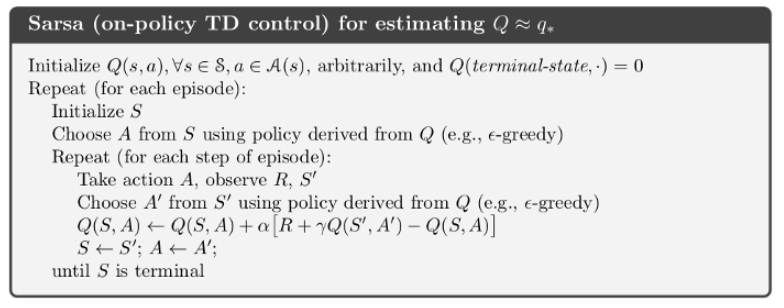

In [2]:
import numpy as np
import pygame
pygame.init()

pygame 2.5.2 (SDL 2.28.3, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


(5, 0)

In [3]:
# Класс окружение
class Environment():

    def __init__(self, worldmap):
        self.worldmap = worldmap
        self.height, self.width = self.worldmap.shape

    def returnState(self, position, action):
        new_position = position
        if action == 'right':
            new_position = [position[0]+1, position[1]]
        if action == 'left':
            new_position = [position[0]-1, position[1]]
        if action == 'down':
            new_position = [position[0], position[1]+1]
        if action == 'up':
            new_position = [position[0], position[1]-1]

        if new_position[0] >= 0 and new_position[0] < self.width and\
        new_position[1] >= 0 and new_position[1] < self.height and\
        self.worldmap[new_position[1],new_position[0]] != 1:
            return new_position
        else:
            return position

    def returnReward(self, position):
        if self.worldmap[position[1],position[0]] == 2: # food
            return 10
        elif self.worldmap[position[1],position[0]] == 3: # danger
            return -100
        else:
            return -1

# Класс аганта
class Agent():

    def __init__(self, env_size=(10, 10), start=[0,0]):
        self.position = start
        self.actions = ['right', 'left', 'down', 'up']
        self.total_reward_each_eps = []
        self.epsilon = .3 # Exploration vs Exploitation
        self.alpha = 0.1
        self.gamma = 1
        self.q_table = {}
        env_height, env_width = env_size
        for i in range(env_width):
            for j in range(env_height):
                self.q_table[(i, j)] = {}
                for a in self.actions:
                    self.q_table[(i, j)][a] = 0  # Q value is a dict of dicts

    def chooseAction(self, position):
        epsilon = self.epsilon
        # Epsilon greedy strategy
        if np.random.uniform(0, 1) <= epsilon:# explore
            return np.random.choice(self.actions)
        else:# exploit
            return max(self.q_table[tuple(position)], key=self.q_table[tuple(position)].get)

    def update(self, cur_state, new_state, action, reward):
        # В методе SARSA необходимо знать следующее действие, чтобы обновить данные в таблице 
        next_action = self.chooseAction(new_state)
        # Q(s, a)
        cur_q = self.q_table[tuple(cur_state)][action]
        # Q(s′,a′) - след состояние 
        next_q = self.q_table[tuple(new_state)][next_action]
        # Q(s,a) + α(r + γ * Q(s′,a′) − Q(s,a))
        self.q_table[tuple(cur_state)][action] += self.alpha * (reward + self.gamma * next_q - cur_q)

# Класс игры
class Game():

    def __init__(self, worldmap):
        self.worldmap = worldmap
        i,j = np.where(self.worldmap == -1)
        self.startfinish = [j[0],i[0]]
        #
        self.environment = Environment(self.worldmap.copy())
        self.agent = Agent(env_size=self.worldmap.shape, start=self.startfinish)
        #
        self.training = True
        self.episode = 0
        self.score = 0

    def reset(self):
        self.score = np.sum(self.agent.total_reward_each_eps)
        self.environment.worldmap = self.worldmap.copy()
        self.agent.position = self.startfinish
        self.agent.total_reward_each_eps = []
        self.episode += 1

    def one_step_simulate(self, agent):
        cur_state = agent.position
        action = agent.chooseAction(cur_state)
        new_state = self.environment.returnState(cur_state, action)
        reward = self.environment.returnReward(new_state)
        agent.total_reward_each_eps.append(reward)

        if self.training: agent.update(cur_state, new_state, action, reward)
        agent.position = new_state

    def simulate(self, num_episode=1000):
        for episode in range(num_episode):
            while True:
                self.one_step_simulate(self.agent)
                cur_state = self.agent.position
                if self.environment.worldmap[cur_state[1],cur_state[0]] == 3 or \
                self.environment.worldmap[cur_state[1],cur_state[0]] == 2:
                    self.reset()
                    break
        return None

    def pygame_render(self, screen, corner = [10, 10]):
        # world
        for i in range(self.environment.width):
            for j in range(self.environment.height):
                if self.environment.worldmap[j,i] == 1:
                    pygame.draw.rect(screen, (150,150,150), (corner[0]+scale*i, corner[1]+scale*j, scale, scale), 2)
                elif self.environment.worldmap[j,i] == 2:
                    pygame.draw.rect(screen, (0,150,0), (corner[0]+scale*i, corner[1]+scale*j, scale, scale), 0)
                elif self.environment.worldmap[j,i] == 3:
                    pygame.draw.rect(screen, (150,0,0), (corner[0]+scale*i, corner[1]+scale*j, scale, scale), 0)
                else:
                    center = (int(corner[0]+scale*(i+.5)), int(corner[1]+scale*(j+.5)))
                    corn1 = [corner[0]+scale*i, corner[1]+scale*j]
                    corn2 = [corner[0]+scale*(i+1), corner[1]+scale*j]
                    corn3 = [corner[0]+scale*(i+1), corner[1]+scale*(j+1)]
                    corn4 = [corner[0]+scale*i, corner[1]+scale*(j+1)]

                    food = 120/10
                    danger = -120/100
                    if self.agent.q_table[(i,j)]['right'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j)]['right']*food),0), \
                                         [center,corn2,corn3])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j)]['right']*danger),0,0), \
                                         [center,corn2,corn3])
                    if self.agent.q_table[(i,j)]['left'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j)]['left']*food),0), \
                                         [center,corn1,corn4])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j)]['left']*danger),0,0), \
                                         [center,corn1,corn4])
                    if self.agent.q_table[(i,j)]['down'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j)]['down']*food),0), \
                                         [center,corn3,corn4])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j)]['down']*danger),0,0), \
                                         [center,corn3,corn4])
                    if self.agent.q_table[(i,j)]['up'] >= 0:
                        pygame.draw.polygon(screen, (0,int(self.agent.q_table[(i,j)]['up']*food),0), \
                                         [center,corn1,corn2])
                    else:
                        pygame.draw.polygon(screen, (int(self.agent.q_table[(i,j)]['up']*danger),0,0), \
                                         [center,corn1,corn2])

        pygame.draw.rect(screen, (0,0,0), \
                         (corner[0], corner[1], scale*self.environment.width, scale*self.environment.height), 4)
        # agent
        pygame.draw.circle(screen, (255,255,255), \
                           (int(corner[0]+scale*(self.agent.position[0]+.5)), \
                            int(corner[1]+scale*(self.agent.position[1]+.5))), \
                           scale//2.5, 4)



In [4]:
# масштаб и расположение игрового поля в окне
scale = 50
topleft = [50,20]

#  0 - обычная ячейка
#  1 - стена
# -1 - стартовая ячейка
#  2 - целевая ячейка (конец эпизода)
#  3 - ячейка с ловушкой (конец эпизода)
#
world = np.array([ [0,0,0,0,0,0,0,0,0,0,0,0], \
                   [0,0,0,0,0,0,0,0,0,0,0,0], \
                   [0,0,0,0,0,0,0,0,0,0,0,0], \
                  [-1,3,3,3,3,3,3,3,3,3,3,2]])
values = {}

game = Game(world)
print(game.worldmap)

if values == {}:
    game.simulate(1200) # количество эпизодов обучения в фоновом режиме
else:
    game.agent.q_table = values

[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [-1  3  3  3  3  3  3  3  3  3  3  2]]


In [5]:
bg_color = (255,255,255)
(width,height) = (900,280)

pygame.display.init()
myfont1 = pygame.font.SysFont("monospace", 12)
screen = pygame.display.set_mode((width,height))
pygame.display.set_caption("RL")

game.training = True # демонстрация без обучения
time = 0
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    time += 1
    if time % 30 == 0:
        game.one_step_simulate(game.agent)
        cur_state = game.agent.position
        if game.environment.worldmap[cur_state[1],cur_state[0]] == 3 or \
        game.environment.worldmap[cur_state[1],cur_state[0]] == 2:
            game.reset()
    screen.fill(bg_color)
    game.pygame_render(screen, topleft)
    screen.blit(myfont1.render("episode: "+str(game.episode), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]))
    screen.blit(myfont1.render("prev score: "+"{:2.1f}".format(game.score), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]+15))
    #screen.blit(myfont1.render("exploration: "+"{:1.3f}".format(game.agent.epsilon), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]+30))
    #screen.blit(myfont1.render("learning rate: "+"{:1.3f}".format(game.agent.alpha), 1, (255,0,0)), (topleft[0]+scale*game.environment.width+50, topleft[1]+45))


    pygame.display.update()


pygame.display.quit()